# 1. Model description

In [1]:
using ReachabilityAnalysis, BenchmarkTools, Plots

In [2]:
@taylorize function laubloomis!(dx, x, params, t)
    dx[1] = 1.4*x[3] - 0.9*x[1]
    dx[2] = 2.5*x[5] - 1.5*x[2]
    dx[3] = 0.6*x[7] - 0.8*(x[2]*x[3])
    dx[4] = 2 - 1.3*(x[3]*x[4])
    dx[5] = 0.7*x[1] - (x[4]*x[5])
    dx[6] = 0.3*x[1] - 3.1*x[6]
    dx[7] = 1.8*x[6] - 1.6*(x[2]*x[7])
    return dx
end

# 2. Reachability settings

We consider three different instances, for different values of the width $W$ of the initial set.

In [20]:
W = [0.01, 0.05, 0.1] # width of the initial set for each instance
c = [1.2, 1.05, 1.5, 2.4, 1.0, 0.1, 0.45]; # center of initial conditions
X0 = [Hyperrectangle(c, fill(Wi, 7)) for Wi in W];
prob = [@ivp(x' = laubloomis!(x), dim: 7, x(0) ∈ X0i) for X0i in X0];

# 3. Results

In [21]:
@btime sol1 = solve($prob[1], T=20.0, alg=TMJets(abs_tol=1e-10, orderT=7, orderQ=1))
sol1z = overapproximate(sol1, Zonotope);

  1.130 s (20787239 allocations: 1.13 GiB)


In [22]:
@btime sol2 = solve($prob[2], T=20.0, alg=TMJets(abs_tol=1e-10, orderT=7, orderQ=1))
sol2z = overapproximate(sol2, Zonotope);

  1.484 s (28699425 allocations: 1.46 GiB)


In [23]:
@btime sol3 = solve($prob[3], T=20.0, alg=TMJets(abs_tol=1e-10, orderT=7, orderQ=1))
sol3z = overapproximate(sol3, Zonotope);

  1.404 s (29213762 allocations: 1.47 GiB)


Check that property holds. For instances `W[1]` and `W[2]` it is required that the maximum value of $x_4(t)$ is 4.5, and for instance `W[3]`, the value of $x_4(t)$ should not exceed 5.0.

In [27]:
using LazySets: SingleEntryVector

up4 = SingleEntryVector(4, 7, 1.0)

@show ρ(up4, sol1z)
@show ρ(up4, sol2z)
@show ρ(up4, sol3z)

ρ(up4, sol1z) = 4.346317483414374
ρ(up4, sol2z) = 4.46156886871561
ρ(up4, sol3z) = 4.606300071405218


4.606300071405218

Compute width of the final set with respect to the variable 4:

In [41]:
@show overapproximate(project(sol1z[end], vars=(4)), Interval) |> set |> diameter
@show overapproximate(project(sol2z[end], vars=(4)), Interval) |> set |> diameter
@show overapproximate(project(sol3z[end], vars=(4)), Interval) |> set |> diameter

(overapproximate(project(sol1z[end], vars = 4), Interval) |> set) |> diameter = 0.003724355691461234
(overapproximate(project(sol2z[end], vars = 4), Interval) |> set) |> diameter = 0.015806340510580164
(overapproximate(project(sol3z[end], vars = 4), Interval) |> set) |> diameter = 0.030924574623156786


0.030924574623156786

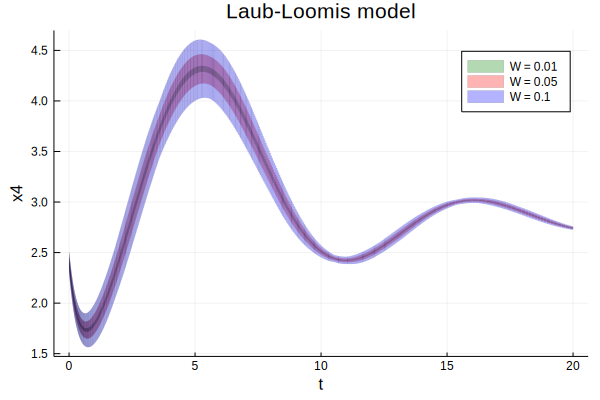

In [49]:
plot(sol1z, vars=(0, 4), color=:green, lw=0.1, lab="W = $(W[1])",
     title="Laub-Loomis model", xlab="t", ylab="x4", alpha=.3)

plot!(sol2z, vars=(0, 4), color=:red, lw=0.1, lab="W = $(W[2])", alpha=.3)

plot!(sol3z, vars=(0, 4), color=:blue, lw=0.1, lab="W = $(W[3])", alpha=.3)

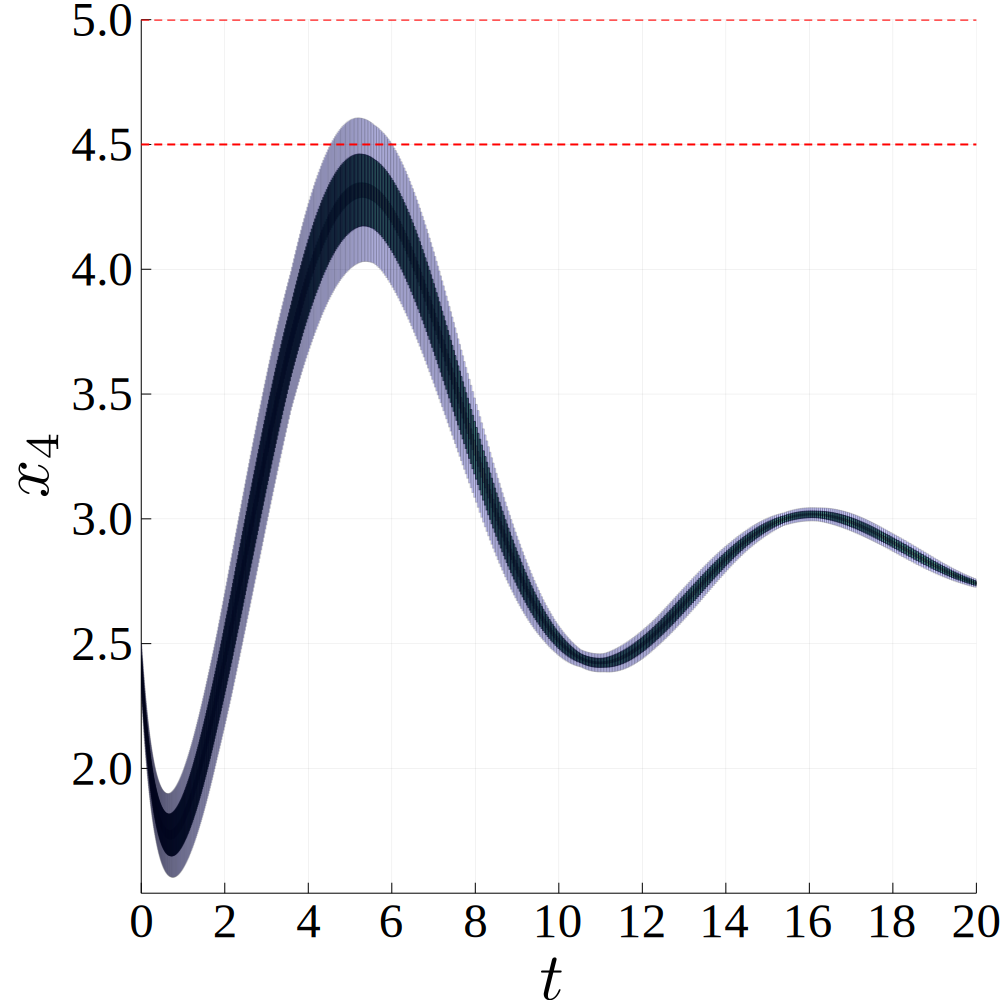

In [53]:
# publication-ready plot
using Plots.PlotMeasures, LaTeXStrings

plot(sol1z, vars=(0, 4), color="red")

plot!(sol2z, vars=(0,4), alpha=0.6, color="green")

plot!(sol3z, vars=(0,4), alpha=0.2,
     tickfont=font(30, "Times"), guidefontsize=45,
     xlab=L"t\raisebox{2.0mm}{\textcolor{white}{.}}",
     ylab=L"x_{4}\raisebox{1.2mm}{\textcolor{white}{.}}",
     xtick=[0., 2., 4., 6., 8., 10., 12., 14., 16., 18., 20.],
     ytick=[2, 2.5, 3, 3.5, 4, 4.5, 5.0],
     xlims=(0., 20.), ylims=(1.5, 5.0),
     bottom_margin=6mm, left_margin=8mm, right_margin=4mm, top_margin=3mm,
     size=(1000, 1000), color="blue")

plot!(x->x, x->5.0, 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)
plot!(x->x, x->4.5, 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)
savefig("laubloomis.png")